<a href="https://colab.research.google.com/github/jhmuller/XCS224/blob/main/Link_Prediction_with_DeepSNAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Link Prediction with DeepSNAP**

This is a tutorial for DeepSNAP link prediction. In this tutorial, we will perform link prediction task by using DeepSNAP.

You might need to **sequentially run all the cells in each section**.

# Installation

Before running the cells, please go to the `Runtime` and `Change runtime type` to `GPU`.

In [ ]:
# Install the packages
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     |████████████████████████████████| 8.0 MB 831 kB/s 
     |████████████████████████████████| 48 kB 2.1 MB/s 


# DeepSNAP Link Prediction Basics

In this section, we will go through the basics of the DeepSNAP link prediction.

## Setup

In [ ]:
import torch
import warnings
import networkx as nx
import matplotlib.pyplot as plt

from pylab import *
from copy import deepcopy
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch.utils.data import DataLoader

# Disable DeepSNAP warnings for clearer printout in the tutorial
warnings.filterwarnings("ignore")

## Transductive Link Prediction Split

Link prediction is usually an unsupervised or self-supervised task, which means that sometimes we need to split the dataset and create corresponding labels on our own.

In general, edges in the graph will be splitted to two types. One is the `message passing` edges that used for GNN message passing and another one is the `supervision` edges that will be used in loss function for backpropagation.

For `supervision` edges, we usually need to include negative sampling edges, the edges not existed in the original graph.

DeepSNAP will automatically generate labels for all edges. Negative edges will correspond to label 0. Positive supervision edges usually will correspond to label 1. If the original edges already have labels (started from 0), all the labels will be added by 1. For example, if one edge has original label 3, after dataset split and label generation, the label will be shifted to 4.

In addition to edges split and negative edge sampling, edges in each of the train, validation and test sets usually need to be disjoint. More details will be introduced in this section.

In this section we will use the [karate club graph](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html). To give a better visualization, we will transform the karate club graph into a directed graph.


In [ ]:
G = nx.karate_club_graph().to_directed()
print("The graph has {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))
pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color="grey", connectionstyle='arc3, rad = 0.1')
plt.show()

DeepSNAP link prediction contains two main split modes (`edge_train_mode`).

Now let's go through each modes by examples.

### **Mode: All**

Here is a simple (default) mode for DeepSNAP, the `edge_train_mode="all"` one.

Original DeepSNAP dataset has 156 edges
Train set has 124 supervision (positive) edges
Validation set has 15 supervision (positive) edges
Test set has 17 supervision (positive) edges
Train set has 124 message passing edges
Validation set has 124 message passing edges
Test set has 139 message passing edges


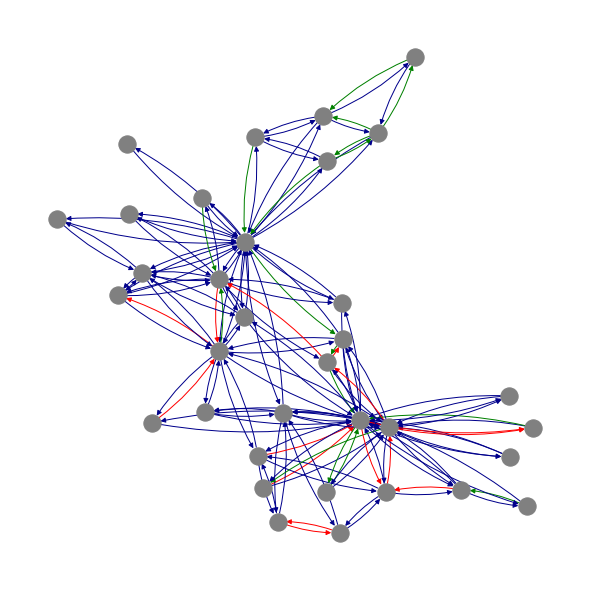

In [ ]:
task = "link_pred"
dg = Graph(G)
# Transform to DeepSNAP dataset
dataset = GraphDataset([dg], task=task, edge_train_mode="all")
print("Original DeepSNAP dataset has {} edges".format(dataset.num_edges[0]))

# Split the dataset
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])
num_train_edges = dataset_train[0].edge_label_index.shape[1]
num_val_edges = dataset_val[0].edge_label_index.shape[1]
num_test_edges = dataset_test[0].edge_label_index.shape[1]

print("Train set has {} supervision (positive) edges".format(num_train_edges // 2))
print("Validation set has {} supervision (positive) edges".format(num_val_edges // 2))
print("Test set has {} supervision (positive) edges".format(num_test_edges // 2))

print("Train set has {} message passing edges".format(dataset_train[0].edge_index.shape[1]))
print("Validation set has {} message passing edges".format(dataset_val[0].edge_index.shape[1]))
print("Test set has {} message passing edges".format(dataset_test[0].edge_index.shape[1]))

edge_color = {}

for i in range(num_train_edges // 2):
    edge = dataset_train[0].edge_label_index[:, i]
    edge = (edge[0].item(), edge[1].item())
    edge_color[edge] = 'darkblue'
for i in range(num_val_edges // 2):
    edge = dataset_val[0].edge_label_index[:, i]
    edge = (edge[0].item(), edge[1].item())
    edge_color[edge] = 'red'
for i in range(num_test_edges // 2):
    edge = dataset_test[0].edge_label_index[:, i]
    edge = (edge[0].item(), edge[1].item())
    edge_color[edge] = 'green'

H = deepcopy(G)
nx.classes.function.set_edge_attributes(H, edge_color, name='color')
colors = nx.get_edge_attributes(H, 'color').values()
plt.figure(figsize=(8, 8))
nx.draw(H, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color="grey", edge_color=colors, connectionstyle='arc3, rad = 0.1')
plt.show()

The figure above shows the supervision edges in train (blue), validation (red) and test (green) sets. Notice that all original edges in `all` mode will be included in the supervision edges.

**To be more specific**:

* At training time: the training supervision edges are same with the training message passing edges.
* At validation time: the message passing edges are the training message passing edges and training supervision edges (still the training message passing edges in this case). The validation supervision edges are disjoint with training supervision edges.
* At test time: the message passing edges are the union of training message passing edges, training supervision edges, and validation supervision edges. The test supervision edges are disjoint with training supervision edges and validation supervision edges.

### **Mode: Disjoint**

Original DeepSNAP dataset has 156 edges
Train set has 25 supervision (positive) edges
Validation set has 15 supervision (positive) edges
Test set has 17 supervision (positive) edges
Train set has 99 message passing edges
Validation set has 124 message passing edges
Test set has 139 message passing edges


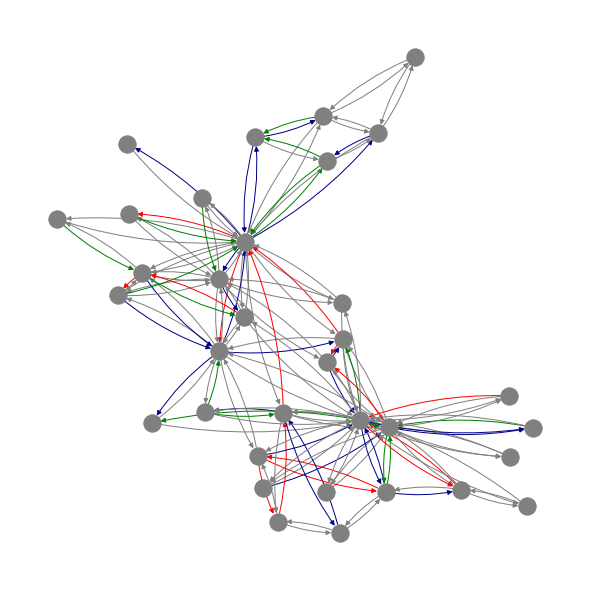

In [ ]:
# Disjoint mode
dataset = GraphDataset([dg], task=task, edge_train_mode="disjoint")
print("Original DeepSNAP dataset has {} edges".format(dataset.num_edges[0]))

# Split the dataset
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])
num_train_edges = dataset_train[0].edge_label_index.shape[1]
num_val_edges = dataset_val[0].edge_label_index.shape[1]
num_test_edges = dataset_test[0].edge_label_index.shape[1]

print("Train set has {} supervision (positive) edges".format(num_train_edges // 2))
print("Validation set has {} supervision (positive) edges".format(num_val_edges // 2))
print("Test set has {} supervision (positive) edges".format(num_test_edges // 2))

print("Train set has {} message passing edges".format(dataset_train[0].edge_index.shape[1]))
print("Validation set has {} message passing edges".format(dataset_val[0].edge_index.shape[1]))
print("Test set has {} message passing edges".format(dataset_test[0].edge_index.shape[1]))


edge_color = {}

for i in range(num_train_edges // 2):
    edge = dataset_train[0].edge_label_index[:, i]
    edge = (edge[0].item(), edge[1].item())
    edge_color[edge] = 'darkblue'
for i in range(num_val_edges // 2):
    edge = dataset_val[0].edge_label_index[:, i]
    edge = (edge[0].item(), edge[1].item())
    edge_color[edge] = 'red'
for i in range(num_test_edges // 2):
    edge = dataset_test[0].edge_label_index[:, i]
    edge = (edge[0].item(), edge[1].item())
    edge_color[edge] = 'green'
for edge in G.edges():
    if edge not in edge_color:
        edge_color[edge] = "grey"

H = deepcopy(G)
nx.classes.function.set_edge_attributes(H, edge_color, name='color')
colors = nx.get_edge_attributes(H, 'color').values()
plt.figure(figsize=(8, 8))
nx.draw(H, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color="grey", edge_color=colors, connectionstyle='arc3, rad = 0.1')
plt.show()

The figure above shows the supervision edges in train (blue), validation (red), test (green) sets and the training message passing edges (grey). Notice that not all original edges in `disjoint` mode will be included in the supervision edges.

**To be more specific**:

* At training time: the training supervision edges are disjoint with the training message passing edges.
* At validation time: the message passing edges are the union of training message passing edges and training supervision edges. Notice that the validation supervision edges are disjoint with training supervision edges.
* At test time: the message passing edges are the training message passing edges, training supervision edges, and validation supervision edges. The test supervision edges are disjoint with training supervision edges and validation supervision edges.

## Inductive Link Prediction Split

For inductive link prediction in DeepSNAP, graphs will be splitted to different (train, validation and test) sets. Each graph in the same set will have message passing edges and supervision edges (which are same in this case). But supervision and message passing edges in each graph in different sets are disjoint.

In [ ]:
# Copy the graph 10 times
dgs = [deepcopy(dg) for i in range(10)]
dataset = GraphDataset(dgs, task=task)

# Split the dataset
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=False, split_ratio=[0.8, 0.1, 0.1])
print("There are {} graphs in training set".format(len(dataset_train)))
print("There are {} graphs in validation set".format(len(dataset_val)))
print("There are {} graphs in test set".format(len(dataset_test)))

There are 8 graphs in training set
There are 1 graphs in validation set
There are 1 graphs in test set


## Negative Sampling Ratio and Resampling

For `link_pred` task, DeepSNAP will automatically and randomly sample negative edges when:
* The dataset is splitted to several datasets, such that one dataset is splitted to train, validation and test.
* The `Batch` of the graph is called or used (this will resample all negative edges).

The number or ratio of negative edges can be controlled by specifying the `edge_negative_sampling_ratio`, which has the default value 1. The resampling can be disabled by setting `resample_negatives` to be False. The example below shows how to set different number or ratio of negative edges.

In [ ]:
# Control the negative sampling ratio
ratio = 1
dataset = GraphDataset([dg], task=task, edge_negative_sampling_ratio=ratio)
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])
train_num_negative = dataset_train[0].edge_label.shape[0] - torch.count_nonzero(dataset_train[0].edge_label)
print("There are {} negative edges in training set when sampling ratio is {}".format(
    train_num_negative.item(), ratio))

ratio = 2
dataset = GraphDataset([dg], task=task, edge_negative_sampling_ratio=ratio)
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])
train_num_negative = dataset_train[0].edge_label.shape[0] - torch.count_nonzero(dataset_train[0].edge_label)
print("There are {} negative edges in training set when sampling ratio is {}".format(
    train_num_negative.item(), ratio))

There are 124 negative edges in training set when sampling ratio is 1
There are 248 negative edges in training set when sampling ratio is 2


From following example, you can see that the training set negative edges will be resampled when the `Batch` object is called. However, to reduce the computation cost, the validation and test sets negative edges will not be resampled.

In [ ]:
dataset = GraphDataset([dg], task=task)
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])
dataloaders = {
    "train": DataLoader(
        dataset_train, collate_fn=Batch.collate([]), shuffle=True),
    "val": DataLoader(
        dataset_val, collate_fn=Batch.collate([]), shuffle=True),
    "test": DataLoader(
        dataset_test, collate_fn=Batch.collate([]), shuffle=True),
}
neg_edges_1 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  break
neg_edges_2 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  break
print("1st iteration and 2nd iteration training negative edges are equal -> {}".format(
    torch.equal(neg_edges_1, neg_edges_2)
))

neg_edges_1 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  break
neg_edges_2 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  break

print("1st iteration and 2nd iteration validation negative edges are equal -> {}".format(
    torch.equal(neg_edges_1, neg_edges_2)
))

1st iteration and 2nd iteration training negative edges are equal -> False
1st iteration and 2nd iteration validation negative edges are equal -> True


## Message Passing Ratio

Here is an example of adjusting the number of message passing edges and supervision edges in `disjoint` mode. We can control the number of edges by adjusting the `edge_message_ratio`, which defines the ratio between message-passing edges and supervision edges in the training set.

In [ ]:
mode = "disjoint"
ratio = 0.5
dataset = GraphDataset([dg], task=task, edge_train_mode=mode, edge_message_ratio=ratio)
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])
num_message_edges = dataset_train[0].edge_index.shape[1]
num_supervision_edges = dataset_train[0].edge_label.shape[0] // 2
print("There are {} message passing edges in training set when sampling ratio is {}".format(
    num_message_edges, ratio))
print("There are {} supervision edges in training set when sampling ratio is {}".format(
    num_supervision_edges, ratio))

ratio = 0.8
dataset = GraphDataset([dg], task=task, edge_train_mode=mode, edge_message_ratio=ratio)
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])
num_message_edges = dataset_train[0].edge_index.shape[1]
num_supervision_edges = dataset_train[0].edge_label.shape[0] // 2
print("There are {} message passing edges in training set when sampling ratio is {}".format(
    num_message_edges, ratio))
print("There are {} supervision edges in training set when sampling ratio is {}".format(
    num_supervision_edges, ratio))

There are 62 message passing edges in training set when sampling ratio is 0.5
There are 62 supervision edges in training set when sampling ratio is 0.5
There are 99 message passing edges in training set when sampling ratio is 0.8
There are 25 supervision edges in training set when sampling ratio is 0.8


There are other parameters you can set or adjust for the link prediction task, more details please refer to the [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html#deepsnap-graphdataset).

# Link Prediction on Cora Graph

Now let's perform transductive link prediction task on the `Cora` graph by using the DeepSNAP!

## Setup

In [ ]:
import copy
import torch
import torch.nn as nn
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from sklearn.metrics import roc_auc_score
from torch_geometric.datasets import Planetoid, TUDataset
from torch.utils.data import DataLoader
from torch_geometric.nn import SAGEConv

## A Simple GNN Model

In [ ]:
class LinkPredModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LinkPredModel, self).__init__()

        self.conv1 = SAGEConv(input_size, hidden_size)
        self.conv2 = SAGEConv(hidden_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def forward(self, batch):
        x, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)

        nodes_first = torch.index_select(x, 0, edge_label_index[0,:].long())
        nodes_second = torch.index_select(x, 0, edge_label_index[1,:].long())
        pred = torch.sum(nodes_first * nodes_second, dim=-1)
        return pred
    
    def loss(self, pred, label):
        return self.loss_fn(pred, label)

## Train and Test

In [ ]:
def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            
            batch.to(args["device"])
            model.train()
            optimizer.zero_grad()
            pred = model(batch)
            loss = model.loss(pred, batch.edge_label.type(pred.dtype))

            loss.backward()
            optimizer.step()

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {:.5f}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
    return best_model

def test(model, dataloader, args):
    model.eval()
    score = 0
    num_batches = 0
    for batch in dataloader:
        batch.to(args["device"])
        pred = model(batch)
        pred = torch.sigmoid(pred)
        score += roc_auc_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
        num_batches += 1
    score /= num_batches 
    return score

## Start Training!

Let's start training!

In [ ]:
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "epochs" : 150,
}

pyg_dataset = Planetoid('./tmp/cora', 'Cora')
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

dataset = GraphDataset(
        graphs,
        task='link_pred',
        edge_train_mode="disjoint"
    )
datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.85, 0.05, 0.1])
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

model = LinkPredModel(input_dim, args["hidden_dim"]).to(args["device"])

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(log.format(best_train_roc, best_val_roc, best_test_roc))

Processing...
Done!
Epoch: 001, Train: 0.8151, Val: 0.7457, Test: 0.7742, Loss: 3.78755
Epoch: 002, Train: 0.8308, Val: 0.7756, Test: 0.7841, Loss: 3.42163
Epoch: 003, Train: 0.8282, Val: 0.7828, Test: 0.7757, Loss: 3.26617
Epoch: 004, Train: 0.8236, Val: 0.7797, Test: 0.7685, Loss: 3.05734
Epoch: 005, Train: 0.8250, Val: 0.7725, Test: 0.7680, Loss: 2.82627
Epoch: 006, Train: 0.8194, Val: 0.7661, Test: 0.7684, Loss: 2.88806
Epoch: 007, Train: 0.8300, Val: 0.7669, Test: 0.7748, Loss: 2.53912
Epoch: 008, Train: 0.8427, Val: 0.7705, Test: 0.7808, Loss: 2.28713
Epoch: 009, Train: 0.8493, Val: 0.7714, Test: 0.7852, Loss: 2.55264
Epoch: 010, Train: 0.8472, Val: 0.7694, Test: 0.7884, Loss: 2.08739
Epoch: 011, Train: 0.8560, Val: 0.7694, Test: 0.7920, Loss: 1.97216
Epoch: 012, Train: 0.8484, Val: 0.7683, Test: 0.7922, Loss: 1.99673
Epoch: 013, Train: 0.8575, Val: 0.7673, Test: 0.7913, Loss: 2.05574
Epoch: 014, Train: 0.8632, Val: 0.7684, Test: 0.7911, Loss: 1.61454
Epoch: 015, Train: 0.8584, V

More examples such as the inductive link prediction please see the [examples/link_prediction](https://github.com/snap-stanford/deepsnap/tree/master/examples/link_prediction) folder.

[Next: Graph Classification with DeepSNAP](https://colab.research.google.com/drive/1EwPZXpmG1Sbbfkq1g8QJhpflXBCzaQJI?usp=sharing)